In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [1]:
!conda install swig
!pip install box2d-py

Solving environment: / - \ | / - \ done

# All requested packages already installed.



In [2]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
import matplotlib.pyplot as plt


In [3]:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

In [4]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [5]:
class DuelingLinearDeepQNetwork(nn.Module):
    def __init__(self, ALPHA, n_actions, name, input_dims, chkpt_dir='tmp/dqn'):
        super(DuelingLinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.V = nn.Linear(128, 1)
        self.A = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_dqn')

    def forward(self, state):
        l1 = F.relu(self.fc1(state))
        l2 = F.relu(self.fc2(l1))
        V = self.V(l2)
        A = self.A(l2)

        return V, A

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [6]:
class Agent(object):
    def __init__(self, gamma, epsilon, alpha, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        self.batch_size = batch_size
        self.replace_target_cnt = replace
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DuelingLinearDeepQNetwork(alpha, n_actions, input_dims=input_dims,
                                   name='q_eval', chkpt_dir=chkpt_dir)
        self.q_next = DuelingLinearDeepQNetwork(alpha, n_actions, input_dims=input_dims,
                                   name='q_next', chkpt_dir=chkpt_dir)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            observation = observation[np.newaxis,:]
            state = T.tensor(observation).to(self.q_eval.device)
            _, advantage = self.q_eval.forward(state)
            action = T.argmax(advantage).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def replace_target_network(self):
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                         if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        # using T.Tensor seems to reset datatype to float
        # using T.tensor preserves source data type
        state = T.tensor(state).to(self.q_eval.device)
        new_state = T.tensor(new_state).to(self.q_eval.device)
        action = T.tensor(action).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)

        V_s, A_s = self.q_eval.forward(state)
        V_s_, A_s_ = self.q_next.forward(new_state)

        q_pred = T.add(V_s, (A_s - A_s.mean(dim=1, keepdim=True))).gather(1,
                                              action.unsqueeze(-1)).squeeze(-1)

        q_next = T.add(V_s_, (A_s_ - A_s_.mean(dim=1, keepdim=True)))
        q_target = rewards + self.gamma*T.max(q_next, dim=1)[0].detach()
        q_target[dones] = 0.0

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


episode:  0 score -212.2   average score -212.2 epsilon 0.96
episode:  1 score -84.7   average score -148.4 epsilon 0.89
episode:  2 score -139.0   average score -145.3 epsilon 0.76
episode:  3 score -93.5   average score -132.3 epsilon 0.67
episode:  4 score -460.6   average score -198.0 epsilon 0.59
episode:  5 score -94.0   average score -180.6 epsilon 0.48
episode:  6 score -328.4   average score -201.7 epsilon 0.39
episode:  7 score -176.2   average score -198.6 epsilon 0.29
episode:  8 score -133.3   average score -191.3 epsilon 0.19
episode:  9 score -349.4   average score -207.1 epsilon 0.07
episode:  10 score -83.9   average score -195.9 epsilon 0.01
episode:  11 score -158.2   average score -192.8 epsilon 0.01
episode:  12 score -208.1   average score -194.0 epsilon 0.01
episode:  13 score -218.4   average score -195.7 epsilon 0.01
episode:  14 score -2.8   average score -182.8 epsilon 0.01
episode:  15 score -52.9   average score -174.7 epsilon 0.01
episode:  16 score -74.7 

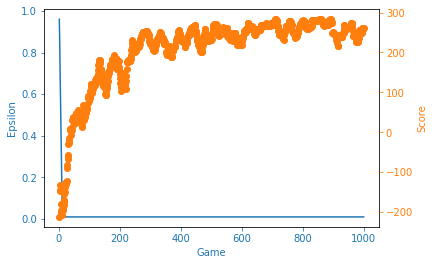

In [7]:
if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    num_games = 1000
    load_checkpoint = False

    agent = Agent(gamma=0.99, epsilon=1.0, alpha=5e-4,
                  input_dims=[8], n_actions=4, mem_size=100000, eps_min=0.01,
                  batch_size=64, eps_dec=1e-3, replace=100)

    if load_checkpoint:
        agent.load_models()

    filename = 'LunarLander-Dueling-DQN.png'
    scores = []
    eps_history = []
    n_steps = 0

    for i in range(num_games):
        done = False
        observation = env.reset()
        score = 0

        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.store_transition(observation, action,
                                    reward, observation_, int(done))
            agent.learn()

            observation = observation_


        scores.append(score)
        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score %.1f ' % score,
             ' average score %.1f' % avg_score,
            'epsilon %.2f' % agent.epsilon)
        #if i > 0 and i % 10 == 0:
        #    agent.save_models()

        eps_history.append(agent.epsilon)

    x = [i+1 for i in range(num_games)]
    plotLearning(x, scores, eps_history, filename)